## Getting started with the AT data

The network data is saved as a dataframe of edges

In [1]:
# import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

the two network specific libraries we want are 
networkx (https://networkx.github.io/documentation/stable/index.html) to create the data frame 
and netwulf to visualise (https://netwulf.readthedocs.io/en/latest/)

In [2]:
import networkx as nx
from netwulf import visualize
import netwulf as wulf

In [3]:
df = pd.read_csv("./edge_data.csv")

In [4]:
df.head(5)

,make_model_a,make_model_b,unique_users,a_unique_users,b_unique_users,P_a,P_b,frac_b_given_a,make_a,model_a,make_b,model_b,category_a,category_b,N_views_a,N_views_b
0,AC Cobra,Land Rover Discovery,124,56408,622785,0.009668,0.106738,0.002198,AC,Cobra,Land Rover,Discovery,CARS,CARS,324,1072
1,Abarth 124 Spider,DS Automobiles DS 7 Crossback,46,71157,99524,0.012195,0.017057,0.000646,Abarth,124 Spider,DS Automobiles,DS 7 Crossback,CARS,CARS,292,441
2,Abarth 124 Spider,Lamborghini Aventador,125,71157,502425,0.012195,0.086110,0.001757,Abarth,124 Spider,Lamborghini,Aventador,CARS,CARS,623,951
3,Abarth 500,Lamborghini Gallardo,307,201459,333119,0.034528,0.057093,0.001524,Abarth,500,Lamborghini,Gallardo,CARS,CARS,1707,1749
4,Abarth 500,Mazda Mazda5,39,201459,128652,0.034528,0.022049,0.000194,Abarth,500,Mazda,Mazda5,CARS,CARS,324,198


The data is organised as a set of edges. 
Each row contains the number of `unique_users` who looked at both `make_model_a` and `make_model_b` within the last 28 days. Only edges with more than 30 `unique_users` are listed.

`a_unique_users` is the total number of users who looked at `make_model_a`, and `P_a` is the probability a user viewed `make_model_a` (N_users who looked at `make_model_a` / Total number of users)

`Frac_b_given_a` is the probability a user would look at `make_model_b` given that they also look at `make_model_a`.

`make`, `model` are just split values of `make_model` in case you want to aggregate.

`N_views_a` is the number of Full Page Advert (FPA) views the `unique_users` performed on `make_model_a`.

`category_a` is the type of vehicle a. The options are:

In [5]:
df['category_a'].unique()

array(['CARS', 'BIKE', 'MOTORHOME', 'COMM', 'TRUCKS', 'CARA'],
      dtype=object)

In [6]:
unique_models = df[['make_model_a','category_a']].drop_duplicates()
# Number of make_models in each vehicle category
unique_models.groupby('category_a').count()

,make_model_a
category_a,
BIKE,918
CARA,11
CARS,1278
COMM,140
MOTORHOME,183
TRUCKS,30


In [7]:
print('Total Number of rows: ',len(df))
print('Number of unique_models: ',len(unique_models))
print('Mean pairs per model: ',len(df)/len(unique_models))

Total Number of rows:  589666
Number of unique_models:  2560
Mean pairs per model:  230.33828125


## Build a simple network 

In [8]:
# For the moment just keep CARS only
df_car = df.loc[(df['category_a']=='CARS') & (df['category_b']=='CARS')]

# We will build a network with scalar weights
# First we want to remove self loops and duplicated AB BA pairs
len(df_car.loc[df_car['make_model_a']==df_car['make_model_b']])

core_df = df_car.loc[df_car['make_model_a']!=df_car['make_model_b']]
core_df = core_df.loc[core_df['make_model_a']<core_df['make_model_b']]
core_df['log10_unique_users'] = np.log10(core_df['unique_users'])

Look at the distribution of unique users across the nodes

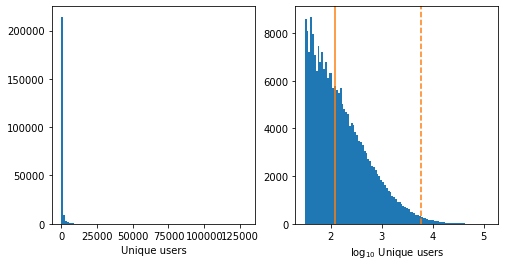

In [9]:
fig, ax = plt.subplots(1,2,figsize=(8,4))

ax[0].hist(core_df['unique_users'],bins=100)
ax[1].hist(core_df['log10_unique_users'],bins=100)

ax[1].axvline(np.median(core_df['log10_unique_users']),color='C1')
ax[1].axvline(np.percentile(core_df['log10_unique_users'],99),ls='--',color='C1')

ax[0].set_xlabel('Unique users')
ax[1].set_xlabel('$\log_{10}$ Unique users')

plt.show()
plt.close(fig)

In [10]:
# In the interest of speed we'll
# limit ourselves to the strongest 1% of connections
# You could randomly sample connections, or nodes as well.
top_1pcnt = np.percentile(core_df['log10_unique_users'],99)

first_graph_df = core_df.loc[core_df['log10_unique_users']>top_1pcnt]

In [11]:
G = nx.from_pandas_edgelist(
    first_graph_df,
    source = 'make_model_a',
    target = 'make_model_b',
    edge_attr = True,
    create_using = nx.Graph()
    )

In [12]:
# Create a dict of make and make_model (node)
mk_dict = df[['make_model_a','make_a']].drop_duplicates(keep='first').set_index('make_model_a').to_dict()['make_a']

# We can link each model with a make (or group)
nx.set_node_attributes(G,mk_dict,'group')
# We have also included unique_users and log10_unique_users as edge attributes

In [13]:
list_of_nodes = list(nx.nodes(G))

print('N nodes: ', len(list_of_nodes))

N nodes:  234


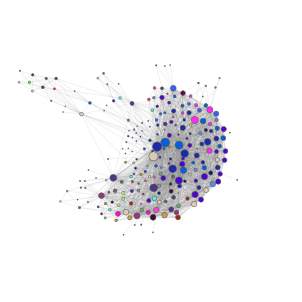

In [47]:
G2 = wulf.tools.get_filtered_network(G,edge_weight_key='log10_unique_users',node_group_key=None)
# The following command will open a new window
# Adjust the sliders and then click "post to python" near the top
stylized_network, config = wulf.visualize(G2, verbose=False)

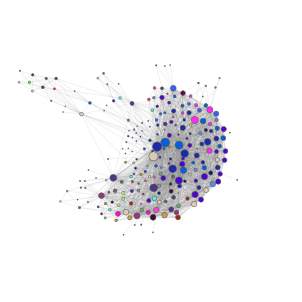

In [48]:
# You can redraw graphs using previous settings
fig, ax = wulf.draw_netwulf(stylized_network)
plt.show()

Be aware that there are cross over vehicles, Vans that are counted as both Commericial and Cars. 
`df.loc[(df['make_model_a']==df['make_model_b']) & (df['category_a']!=df['category_b'])]`

## Print some basic properties of the network

In [14]:
deg_dist = np.asarray(nx.classes.function.degree_histogram(G))

print('Mean degree: ',np.average(np.arange(len(deg_dist)), weights=deg_dist))
print('Mean Log10 degree: ',np.average(np.log10(np.arange(len(deg_dist)-1)+1), weights=deg_dist[1:]))

print('Summary props: \n',nx.classes.function.info(G))

Mean degree:  19.71794871794872
Mean Log10 degree:  0.9506649022376855
Summary props: 
 Name: 
Type: Graph
Number of nodes: 234
Number of edges: 2307
Average degree:  19.7179


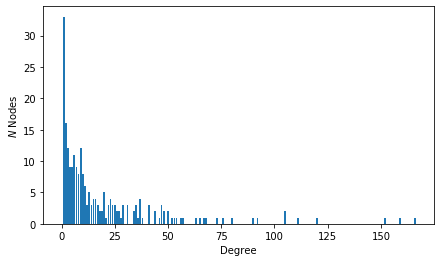

In [15]:
# Distribution of node degrees
hist_vals = nx.degree_histogram(G)
degree_val = np.arange(len(hist_vals))

fig, ax = plt.subplots(figsize=(7,4))
ax.bar(degree_val,hist_vals)

ax.set_xlabel('Degree')
ax.set_ylabel('$N$ Nodes')
plt.show()
plt.close(fig)

In [16]:
# You can get the list of nodes from G.nodes
print(list(G.nodes)[:5])

['Audi A3', 'Audi A4 Avant', 'Porsche Cayenne', 'Audi A7', 'BMW 4 Series']


In [17]:
# You can get simple metrics, like the shortest connection between A & B
nx.shortest_path(G,'Volkswagen Polo','Ferrari 458')

['Volkswagen Polo', 'Audi TT', 'Porsche 911', 'Ferrari 458']

In [18]:
# Clustering coefficient of all nodes (in a dictionary)
clust_coefficients = nx.clustering(G)
# Average clustering coefficient
# Or use directly the built-in method
print(nx.average_clustering(G))

0.7134221654097682


## Centrality
centrality, as the name implies, is a measure of how central or 'important' a node is. There are many ways to measure it. Three examples are given below, with quick explanations.

Betweennes - how often the node appears on the list of shortest paths between other nodes

Closeness - How close is the node to all other nodes

Eigenvector - A node is important if it is connected to other important nodes

In [19]:
# Betweenness centrality
bet_cen = nx.betweenness_centrality(G)
# Closeness centrality
clo_cen = nx.closeness_centrality(G)
# Eigenvector centrality
eig_cen = nx.eigenvector_centrality(G)

In [23]:
def get_top_keys(dictionary, top):
    ret = sorted(dictionary, key=dictionary.get, reverse=True)[:top]
    for i in range(top):
        print("{0:.3f}".format(dictionary[ret[i]]),'\t',ret[i])
    return ret

print('Betweenes Centrality')
top_bet_cent = get_top_keys(bet_cen,5)
print('Closeness Centrality')
top_clo_cent = get_top_keys(clo_cen,5)
print('Eigenvector Centrality')
top_eig_cent = get_top_keys(eig_cen,5)

Betweenes Centrality
0.198 	 BMW 3 Series
0.165 	 Volkswagen Golf
0.133 	 Mercedes-Benz C Class
0.080 	 Volkswagen Transporter
0.067 	 Ford Fiesta
Closeness Centrality
0.769 	 BMW 3 Series
0.748 	 Volkswagen Golf
0.734 	 Mercedes-Benz C Class
0.664 	 Mercedes-Benz E Class
0.643 	 Ford Focus
Eigenvector Centrality
0.214 	 BMW 3 Series
0.213 	 Volkswagen Golf
0.210 	 Mercedes-Benz C Class
0.192 	 Mercedes-Benz E Class
0.183 	 BMW 5 Series


The three methods closely agree with each other for the top connected nodes.

In [24]:
print('Betweeness','\t','Closeness','\t','Eigenvalue')
for i in range(len(top_bet_cent)):
    print(top_bet_cent[i],'\t',top_clo_cent[i],'\t',top_eig_cent[i])

Betweeness 	 Closeness 	 Eigenvalue
BMW 3 Series 	 BMW 3 Series 	 BMW 3 Series
Volkswagen Golf 	 Volkswagen Golf 	 Volkswagen Golf
Mercedes-Benz C Class 	 Mercedes-Benz C Class 	 Mercedes-Benz C Class
Volkswagen Transporter 	 Mercedes-Benz E Class 	 Mercedes-Benz E Class
Ford Fiesta 	 Ford Focus 	 BMW 5 Series


### Clustering
Measured here for each node by how many times it forms 
the vertex of a triangle

In [25]:
#Fraction of possible triangles
print('Transitivity: ',nx.transitivity(G))

print(nx.triangles(G,['Ford Focus','Porsche 911','Mazda MX-5']))

Transitivity:  0.3928727182107034
{'Ford Focus': 1536, 'Porsche 911': 638, 'Mazda MX-5': 10}


### Link prediction
How likely are two nodes to be connected together. There are *many* ways of doing this (see https://arxiv.org/pdf/1901.03425.pdf). Jaccard is one of the most basic.

In [26]:
jac_coeffs = nx.jaccard_coefficient(G,
                                    ebunch=[
                                        ('Ford Focus','Mazda MX-5'),
                                        ('Ford Focus','Porsche 911')
                                    ])

# Jaccard propto likelyhood of two nodes being connected
for u, v, p in jac_coeffs:
    print(u,'-',v,'\t-->\t',p)

Ford Focus - Mazda MX-5 	-->	 0.04504504504504504
Ford Focus - Porsche 911 	-->	 0.23703703703703705


In [27]:
# The rich club metric (https://arxiv.org/pdf/physics/0701290.pdf)

rc_coeffs = nx.rich_club_coefficient(G)

# Degree - RC value
for ii,rc in enumerate(rc_coeffs.values()):
    print(ii,rc)
    if ii>4: break

0 1.0
1 1.0004397537379068
2 1.0004460303300626
3 1.0009066183136899
4 1.0018433179723503
5 1.0018823529411767


## Selecting nodes with given attribute

In [14]:
# Select all nodes where the group attraibute == 'Audi'
selected_nodes = [n for n,v in G.nodes(data=True) if v['group'] == 'Audi'] 
Audi_graph = G.subgraph(selected_nodes)
print(Audi_graph.nodes)

['Audi A6 Saloon', 'Audi A6 Avant', 'Audi Q7', 'Audi RS3', 'Audi S3', 'Audi RS6 Avant', 'Audi S4', 'Audi A1', 'Audi A4 Avant', 'Audi S1', 'Audi SQ5', 'Audi S5', 'Audi TT RS', 'Audi Q8', 'Audi A8', 'Audi RS5', 'Audi A5 Cabriolet', 'Audi TT', 'Audi S4 Avant', 'Audi R8', 'Audi TTS', 'Audi Q3', 'Audi A7', 'Audi A6 Allroad', 'Audi RS7', 'Audi RS4 Avant', 'Audi A3', 'Audi A5', 'Audi Q5', 'Audi A4 Cabriolet', 'Audi A4']


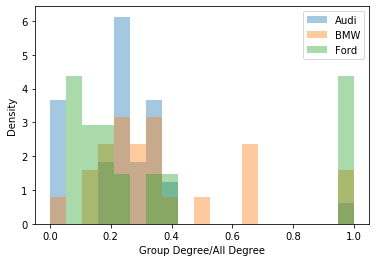

In [18]:
# Look at the degree of nodes within a group (brand) relative to the degree of the nodes
# connected to all nodes
def degree_reduction(G,group='Audi'):
    
    sub_nodes = [n for n,v in G.nodes(data=True) if v['group'] == group]
    brand_graph = G.subgraph(sub_nodes)
    
    brand_self = []
    brand_all = []
    brand_key = []
    for k, d in G.degree:
        if group in k:
            brand_self.append(brand_graph.degree[k])
            brand_all.append(G.degree[k])
            brand_key.append(k)
            
    deg_ratio = np.array(brand_self)/np.array(brand_all)
    return deg_ratio,brand_key

fig, ax = plt.subplots()
bins = np.linspace(0,1,20)
for i in ['Audi','BMW','Ford']:
    deg_ratio,brand_key = degree_reduction(G,group=i)
    ax.hist(deg_ratio,bins=bins,alpha=0.4,density=True,label=i)

ax.set_xlabel('Group Degree/All Degree')
ax.set_ylabel('Density')
ax.legend()
plt.show(fig)
plt.close(fig)

## Additional notes

You can make directed graphs, in these the connection onlly goes one way, so the edge could be P(A|B) one way, and P(B|A) the other. You must read in the pandas edgelist as an undirected graph first, then convert with `G.to_directed()`

Many functions/algorithms are not defined for directed graphs, and the ones that are may not work on undirected graphs.